In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def visualize_city_tifs(parent_folder_path, output_filename_prefix="city_visualization"):
    """
    Scans a parent folder for city subfolders, and for every 5 cities, it
    reads up to 5 .tif images from each, displays them in a large grid, 
    and saves the plot to a file.

    Args:
        parent_folder_path (str): The path to the main directory containing city subfolders.
        output_filename_prefix (str): The prefix for the output image files.
    """
    try:
        # Get a list of all subdirectories (cities) in the parent folder
        all_city_folders = sorted([d for d in os.listdir(parent_folder_path) 
                                   if os.path.isdir(os.path.join(parent_folder_path, d))])
        
        if not all_city_folders:
            print("No city subfolders found in the specified directory.")
            return

        # --- Define grid and batch parameters ---
        rows_per_figure = 5
        cols_per_row = 5  # Max 5 images per city
        
        num_total_cities = len(all_city_folders)
        # Process cities in batches of `rows_per_figure`
        for i in range(0, num_total_cities, rows_per_figure):
            city_batch = all_city_folders[i:i + rows_per_figure]
            
            # --- Create a large figure for the current batch of subplots ---
            num_rows_in_batch = len(city_batch)
            fig, axes = plt.subplots(num_rows_in_batch, cols_per_row, figsize=(cols_per_row * 8, num_rows_in_batch * 8), squeeze=False)

            print(f"\n--- Processing batch {i//rows_per_figure + 1}: {', '.join(city_batch)} ---")
            print(f"Plotting up to {cols_per_row} images for each city...")

            # Loop through each city in the current batch to create a row of plots
            for row_idx, city in enumerate(city_batch):
                city_path = os.path.join(parent_folder_path, city)
                tif_files = sorted([f for f in os.listdir(city_path) if f.lower().endswith(('.tif', '.tiff'))])[:cols_per_row]
                
                # Set the city name as the y-label for the row
                axes[row_idx, 0].set_ylabel(city, fontsize=20, rotation=0, labelpad=60, ha='right')

                # Loop through the images in the city folder to fill the columns
                for col_idx, tif_filename in enumerate(tif_files):
                    ax = axes[row_idx, col_idx]
                    tif_path = os.path.join(city_path, tif_filename)
                    
                    try:
                        # Open and read the .tif file using rasterio
                        with rasterio.open(tif_path) as src:
                            # Read the first 3 bands (assuming RGB)
                            image_data = src.read([1, 2, 3])
                            
                            # Transpose axes for matplotlib: (bands, height, width) -> (height, width, bands)
                            image_for_plot = np.moveaxis(image_data, 0, -1)
                            
                            # Display the image
                            ax.imshow(image_for_plot)
                            ax.set_title(f"Image {col_idx+1}", fontsize=12)
                    except Exception as e:
                        ax.text(0.5, 0.5, 'Error loading image', ha='center', va='center')
                        print(f"Could not process {tif_path}: {e}")

                    ax.set_xticks([])
                    ax.set_yticks([])
                
                # Turn off axes for any unused subplots in the row
                for col_idx in range(len(tif_files), cols_per_row):
                    axes[row_idx, col_idx].axis('off')

            # Adjust layout and save the plot for the current batch
            output_filename = f"{output_filename_prefix}_batch_{i//rows_per_figure + 1}.png"
            plt.tight_layout(pad=3.0)
            print(f"Saving plot to {output_filename} with 300 DPI...")
            plt.savefig(output_filename, dpi=300, bbox_inches='tight')
            plt.close(fig) # Close the figure to free up memory
            print("Plot for batch saved successfully.")

    except FileNotFoundError:
        print(f"Error: The directory '{parent_folder_path}' was not found.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# 1. Set the path to the parent directory containing your city folders
parent_directory = '/Users/slxg3/Downloads/PhD/RA/ClimateTrace/skysat_downloads' 

# 2. Call the function
visualize_city_tifs(parent_directory)

Found 13 cities. Plotting up to 3 images for each...
Saving plot to city_visualization.png with 300 DPI...
Plot saved successfully.


### Analyze download times


Summary statistics for successful downloads:
       activation_seconds  download_seconds  total_seconds
count           36.000000         36.000000      36.000000
mean            48.599444         10.347500      60.816389
std             18.839972         13.804479      25.025794
min              0.000000          1.240000       2.720000
25%             43.537500          1.515000      46.742500
50%             43.635000          2.065000      48.620000
75%             54.247500         21.012500      76.002500
max            119.310000         44.680000     123.810000


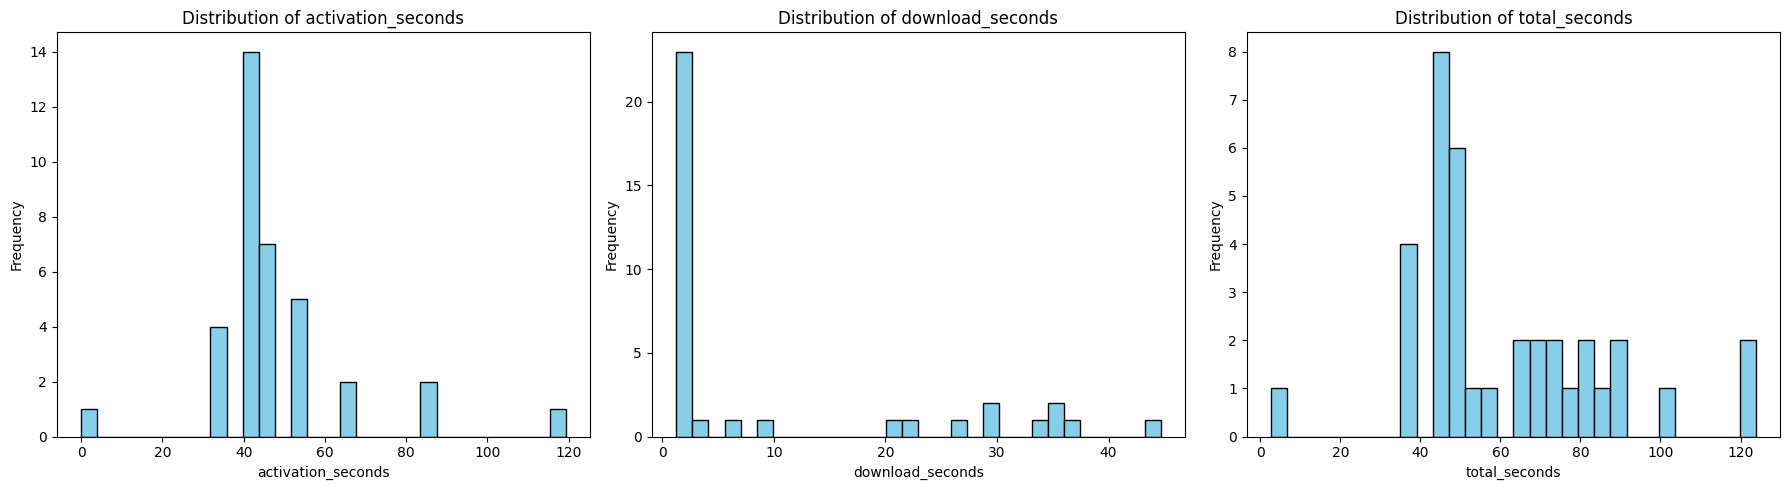

In [6]:
import pandas as pd

import matplotlib.pyplot as plt

# Read the timing data
timings_path = "/Users/slxg3/Downloads/PhD/RA/ClimateTrace/ClimateTRACE/skysat_download_timings.txt"
timings_df = pd.read_csv(timings_path, sep=',', engine='python', header=1)  # auto-detect separator

# Filter for successful downloads
success_df = timings_df[timings_df['status'] == 'success']

# Summary statistics
summary = success_df[['activation_seconds', 'download_seconds', 'total_seconds']].describe()
print("Summary statistics for successful downloads:")
print(summary)

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
columns = ['activation_seconds', 'download_seconds', 'total_seconds']

for i, col in enumerate(columns):
    axes[i].hist(success_df[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()